In [121]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor,StackingRegressor

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [96]:
df = pd.read_csv('bangladesh_student_performance.csv')
df.head()

,date,gender,age,address,famsize,Pstatus,M_Edu,F_Edu,M_Job,F_Job,relationship,smoker,tuition_fee,time_friends,ssc_result,hsc_result
0,29/04/2018,M,18,Rural,GT3,Together,3,2,At_home,Farmer,No,No,71672,4,4.22,3.72
1,29/04/2018,F,19,Rural,LE3,Apart,0,4,Other,Health,Yes,No,26085,5,3.47,2.62
2,29/04/2018,F,19,Rural,GT3,Together,0,3,Teacher,Services,No,No,40891,3,3.32,2.56
3,29/04/2018,F,19,Rural,LE3,Apart,2,3,At_home,Business,No,No,50600,2,4.57,4.17
4,29/04/2018,M,17,Rural,GT3,Together,1,1,At_home,Farmer,No,No,62458,2,4.50,3.94


In [97]:
profile = ProfileReport(df,title='Student performance prediction',explorative=True)
profile.to_file('ydata.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 171.34it/s]


In [98]:
df.columns = ['date', 'gender', 'age', 'address', 'famsize', 'Pstatus',
       'M_Edu', 'F_Edu', 'M_Job', 'F_Job', 'relationship',
       'smoker', 'tuition_fee', 'time_with_friends', 'ssc_result',
       'hsc_result']

In [99]:
# drop date
df.drop(columns=['date'],inplace=True)

In [100]:
df.head()

,gender,age,address,famsize,Pstatus,M_Edu,F_Edu,M_Job,F_Job,relationship,smoker,tuition_fee,time_with_friends,ssc_result,hsc_result
0,M,18,Rural,GT3,Together,3,2,At_home,Farmer,No,No,71672,4,4.22,3.72
1,F,19,Rural,LE3,Apart,0,4,Other,Health,Yes,No,26085,5,3.47,2.62
2,F,19,Rural,GT3,Together,0,3,Teacher,Services,No,No,40891,3,3.32,2.56
3,F,19,Rural,LE3,Apart,2,3,At_home,Business,No,No,50600,2,4.57,4.17
4,M,17,Rural,GT3,Together,1,1,At_home,Farmer,No,No,62458,2,4.50,3.94


In [101]:
df[df.describe().columns].corr()['hsc_result'].sort_values(ascending = False)

hsc_result           1.000000
ssc_result           0.950178
M_Edu                0.063776
F_Edu                0.054811
tuition_fee          0.038068
age                 -0.009857
time_with_friends   -0.156356
Name: hsc_result, dtype: float64

In [102]:
X = df.drop(columns=['hsc_result'])
y = df['hsc_result']

In [103]:
numeric_features = list(X.describe().columns)
categorical_features = list(X.select_dtypes(include='object'))

In [104]:
num_transformer = Pipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('encoder',OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [105]:
preprocessor = ColumnTransformer(transformers=[
    ('num',num_transformer,numeric_features),
    ('cat',cat_transformer,categorical_features)
])

In [106]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [107]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [108]:
# base learner
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [109]:
# voting regressor

voting_reg = VotingRegressor(
    estimators = [
        ('lr',reg_lr),
        ('rf',reg_rf),
        ('gb',reg_gb)
    ]
)

In [110]:
# stacking regressor
stacking_reg = StackingRegressor(
    estimators = [
        ('rf',reg_rf),
        ('gb',reg_gb)
    ],
    final_estimator = Ridge()
)

In [111]:
model_to_train = {
    'Linear Regression':reg_lr,
    'Random Forest':reg_rf,
    'Gradient Boosting':reg_gb,
    'Voting ensemble':voting_reg,
    'Stacking ensemble':stacking_reg
}


In [112]:
result = []
for name,model in model_to_train.items():
    pipe = Pipeline(
        [
            ('Preprocessor',preprocessor),
            ('Model',model)
        ]
    )

    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    result.append({
        'Model name':name,
        'R2 score':r2,
        'RMSE':rmse,
        'MAE':mae
    })

result_df = pd.DataFrame(result).sort_values('R2 score',ascending=False)

In [113]:
result_df

,Model name,R2 score,RMSE,MAE
4,Stacking ensemble,0.959566,0.123105,0.098696
2,Gradient Boosting,0.959565,0.123107,0.098902
3,Voting ensemble,0.957528,0.126169,0.100838
1,Random Forest,0.950248,0.136556,0.108201
0,Linear Regression,0.945920,0.142371,0.111376


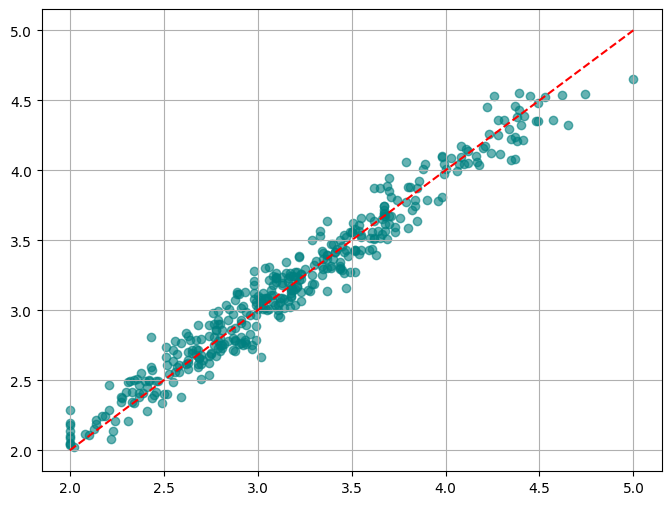

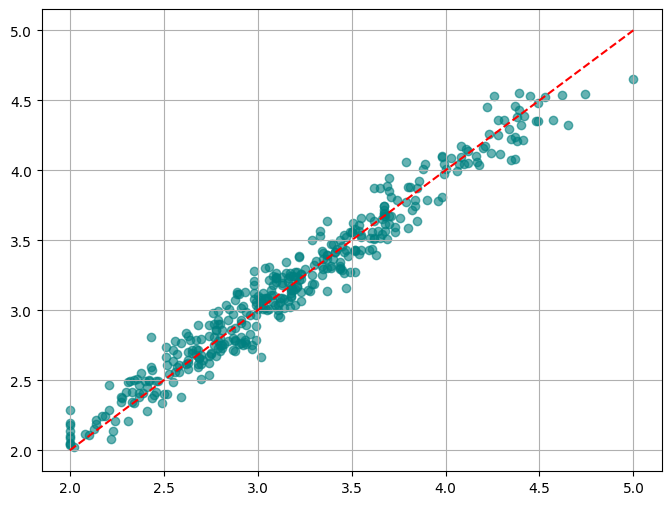

In [122]:
best_model_name = result_df.iloc[0]['Model name']
best_model_obj = model_to_train[best_model_name]
final_pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',best_model_obj)
])
final_pipeline.fit(X_train,y_train)
y_pred = final_pipeline.predict(X_test)


plt.figure(figsize=(8,6))
plt.scatter(x=y_test.values,y=y_pred,alpha=.6,color='teal')
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, 'r--')
plt.grid(True)
plt.show()